In [1]:
import pandas as pd
import yfinance as yf
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

In [2]:
# Get the list of S&P 500 constituents
sp500_tickers = pd.read_excel(
    "https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx",
    header=4).Ticker.dropna().to_list()

# Retrieve historical data
df = yf.download(sp500_tickers, period='10y')
sp500 = df['Adj Close'].dropna(how='all', axis=1)

[*********************100%%**********************]  504 of 504 completed


3 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=10y)')
['-', 'BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')


In [3]:
sp500.tail(1) #Adjusted Close

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2024-02-09 00:00:00,133.339996,14.88,188.850006,174.080002,147.595001,111.809998,83.459999,371.670013,627.210022,195.020004,...,105.599998,58.169998,101.769997,32.790001,124.300003,130.270004,122.800003,253.089996,40.09,197.320007


In [4]:
# Define the time period and lag, can be changed to any number and code will work
time_period = 1260  # 5 years
lag = 20 # lag of 20 days


## Momentum Factors:
 ### Parameter for calculation is used for the backtest. The backtest will run 5 years but can be changed as long as there is sufficient data downloaded.

In [5]:
#how_many_days_back = 0 for current, 1260 for 5 years. It's for backtesting.

def calculate_momentum_factors(how_many_days_back):
# Define the start and end points for the data slice
    start_time = how_many_days_back+ time_period + lag # start at start_time, increase by time_period, include lag
    most_current_time = how_many_days_back+ lag # only difference is the time_period is not included, so we get slice of time period exactly
    
    lagged_closed_price = sp500[-start_time: -most_current_time ] #slice the dataframe to get 5 years
    rolling_mean_price = lagged_closed_price.rolling(window= time_period-251).mean().dropna(how='all') # get the rolling mean price window for 1 year

    # Calculate the 52-week trend
    slope_info = pd.DataFrame(index=sp500.columns)
    for i in range(1, lag + 1): 
        slope_info[i] = rolling_mean_price.apply(
            lambda x: np.polyfit(
                np.arange(len(x[-i - 252: -i])),
                                  x[-i - 252: -i], 1)[0] if x[-i - 252: -i].notna().all() else np.nan) 
    
    _52_week_trend = slope_info.mean(axis=1) 


    # x - x.min() / x.min() * 100 where x is the adjusted close price of our 500 stocks during the stored slice of time period
    percent_above_260 = (lagged_closed_price - lagged_closed_price.rolling(window=260).min()) / lagged_closed_price.rolling(window=260).min() * 100
    percent_above_260 = percent_above_260.dropna(how='all').mean()

    # Rolling 4 week mean - rolling 52 week mean / rolling 52 week mean * 100
    oscillator = (lagged_closed_price.rolling(window=4*5).mean() - lagged_closed_price.rolling(window=52*5).mean()) / lagged_closed_price.rolling(window=52*5).mean() * 100
    oscillator = oscillator.dropna(how='all').mean()    

    # percent change of the adjusted close price over 39 weeks
    returns_39w = lagged_closed_price.pct_change(periods= 39 * 5).dropna(how='all').mean() 
    

    # 51 week Volume Price Trend
    volume = df['Volume'].dropna(how='all', axis=1)[-lag - time_period: -lag]
    vpt = (volume * lagged_closed_price.pct_change()).cumsum() # volume price trend is the cumulative sum of volume * pct_change 
    vpt_51w = (vpt - vpt.shift(periods=51 * 5)).dropna(how='all').mean()
    # the shift is used to shift the df by 51 weeks so that we can calculate the difference between the current and prior 51 week period 
    

    # Creating the DataFrame
    new_table = pd.DataFrame(index=sp500.transpose().index)
    new_table['Slope 52 Week Trend-Line'] = _52_week_trend
    new_table['Percent above 260 Day Low'] = percent_above_260
    new_table['4/52 Week Oscillator'] = oscillator
    new_table['39_Week_Return'] = returns_39w
    new_table['51 Week Volume Price Trend'] = vpt_51w
    return new_table

## Momentum factors (5 years prior to current date) (20 day lag)

Aggregate factors with z-score calculation. Z-scores will determine the long basket and short basket.

In [6]:
momentum_factors = calculate_momentum_factors(0)
momentum_factors

,Slope 52 Week Trend-Line,Percent above 260 Day Low,4/52 Week Oscillator,39_Week_Return,51 Week Volume Price Trend
A,0.051288,38.124339,6.542862,0.130321,9.600529e+04
AAL,-0.015576,44.432220,-7.057185,-0.048412,9.207192e+07
AAPL,0.124718,58.707716,15.074444,0.312060,3.146246e+07
ABBV,0.081509,39.427695,10.130867,0.181420,-1.025897e+06
ABNB,NaN,34.895090,-5.098187,-0.037431,1.514755e+06
...,...,...,...,...,...
YUM,0.030969,36.271666,3.409371,0.070949,4.633774e+04
ZBH,0.006722,33.573261,-0.298319,0.030121,-8.408072e+04
ZBRA,0.065967,56.098882,3.525569,0.135702,-1.313394e+05
ZION,-0.006707,55.446538,-0.934785,0.035911,-1.626813e+06


In [7]:
# Path
excel_file_path = 'resources/momentum_factors.xlsx'

# Save the DataFrame to Excel
momentum_factors.to_excel(excel_file_path, index=True)

In [8]:
def calculate_z_scores(x): # where x is equal to momentum_factors
    z_scores = (x - x.mean()) / x.std() # standard z score formula
    z_scores = z_scores.sum(axis=1) # summing the z-scores of each factor to get the total z-score per asset
    # The z-score is the number of standard deviations away from the mean a data point is.
    return z_scores.sort_values(ascending=False) # sorts the z-scores in descending order

long_basket = calculate_z_scores(momentum_factors)[:10] # selects the top 10 z-scores
short_basket = calculate_z_scores(momentum_factors)[-10:] # selects the bottom 10 z-scores

# basket_df = pd.DataFrame({'Long Basket': long_basket, 'Short Basket': short_basket})

# # Display the DataFrame
# print(basket_df)

print("Long Basket:")
print(long_basket)
print("\nShort Basket:")
print(short_basket)

def get_lagged_closed_price(how_many_days_back):
    start_time = how_many_days_back+ time_period + lag # start at start_time, increase by time_period, include lag
    most_current_time = how_many_days_back+ lag # only difference is the time_period is not included, so we get slice of time period exactly
    # Calculate the rolling mean price
    lagged_closed_price = sp500[-start_time: -most_current_time ]
    return lagged_closed_price

lagged_closed_price = get_lagged_closed_price(0)
# Filter lagged_closed_price based on long_basket and short_basket indices
long_lagged_closed_price = lagged_closed_price[long_basket.index]
short_lagged_closed_price = lagged_closed_price[short_basket.index]

Long Basket:
TSLA    42.095364
MRNA    19.622910
NVDA    17.443036
ENPH    16.473510
NVR     15.321729
BLDR     9.855918
CMG      9.589176
AZO      9.490900
AMD      9.238082
FCX      8.320266
dtype: float64

Short Basket:
VZ     -5.139591
BXP    -5.182979
PARA   -5.285460
WBA    -5.428778
ILMN   -5.464839
WBD    -5.912397
VTRS   -6.064513
BAX    -6.157345
FIS    -6.304956
VFC    -7.792377
dtype: float64


## Creating the Back-Tested Baskets

In [9]:
# First get the momentum factors
momentum_factors_past_5y = calculate_momentum_factors(1260) # 5 years
# Then get the z-scores
long_basket_past_5y = calculate_z_scores(momentum_factors_past_5y)[:10] # selects the top 10 z-scores
short_basket_past_5y =  calculate_z_scores(momentum_factors_past_5y)[-10:] # selects the top 10 z-scores


print("Long Basket Past 5 Years:")
print (long_basket_past_5y)
print("Short Basket Past 5 Years:")
print(short_basket_past_5y)


lagged_closed_price_past_5y = get_lagged_closed_price(1260)
# Filter lagged_closed_price based on long_basket and short_basket indices
long_lagged_closed_price_past_5y = get_lagged_closed_price(1260)[long_basket_past_5y.index]
short_lagged_closed_price_past_5y = get_lagged_closed_price(1260)[short_basket_past_5y.index]


Long Basket Past 5 Years:
NVR     19.063471
NVDA    17.284064
AMD     15.622127
CZR     13.480241
ETSY    13.125444
NFLX    12.261340
ALGN    11.314212
PAYC    11.099165
TTWO     8.177506
ENPH     8.087967
dtype: float64
Short Basket Past 5 Years:
KMI   -4.933413
F     -4.999179
BEN   -5.207880
HWM   -5.239194
MCK   -5.476618
APA   -5.522751
SLB   -5.632803
CMG   -5.645434
EQT   -6.529149
GE    -6.658505
dtype: float64


/var/folders/8n/frf4cdjd6k134p3nvgp4kf6c0000gn/T/ipykernel_7304/4230148870.py:31: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_39w = lagged_closed_price.pct_change(periods= 39 * 5).dropna(how='all').mean()
/var/folders/8n/frf4cdjd6k134p3nvgp4kf6c0000gn/T/ipykernel_7304/4230148870.py:36: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  vpt = (volume * lagged_closed_price.pct_change()).cumsum() # volume price trend is the cumulative sum of volume * pct_change


## Cumulative Returns

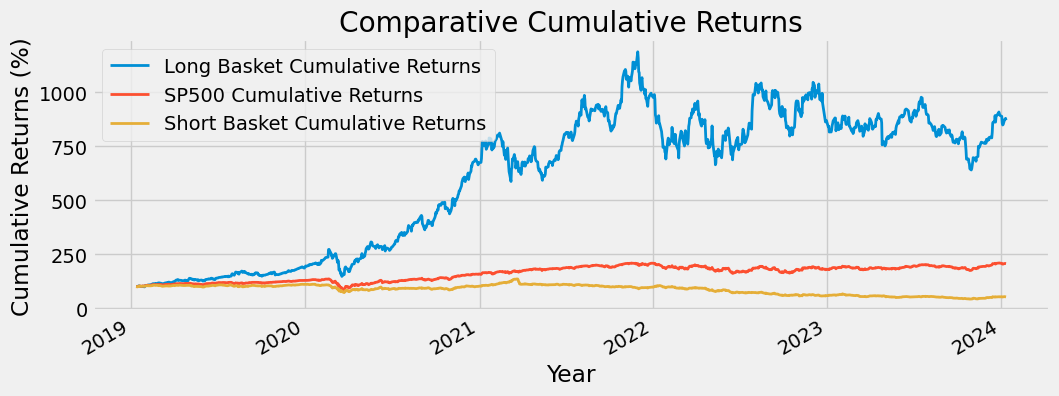

In [10]:
def calculate_cumulative_returns(dataf): 
    returns = dataf.pct_change()
    cumulative_returns = (1 + returns).cumprod().mean(axis=1)*100
    return cumulative_returns

# Calculate the cumulative returns for the SP500, long basket, and short basket
cumulative_returns = calculate_cumulative_returns(lagged_closed_price)
long_cumulative_returns = calculate_cumulative_returns(long_lagged_closed_price)
short_cumulative_returns = calculate_cumulative_returns(short_lagged_closed_price)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
long_cumulative_returns.plot(label='Long Basket Cumulative Returns', lw=2) # lw is line width
cumulative_returns.plot(label='SP500 Cumulative Returns', lw =2)
short_cumulative_returns.plot(label='Short Basket Cumulative Returns', lw=2)

plt.legend()
plt.title('Comparative Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()

In [21]:
print("Long Basket Cumulative Returns: Most current day")
print(long_cumulative_returns[-1])
print("Short Basket Cumulative Returns: Most current day")
print(short_cumulative_returns[-1])
print("SP500 Cumulative Returns: Most current day")
print(cumulative_returns[-1])

Long Basket Cumulative Returns: Most current day
870.3207768241163
Short Basket Cumulative Returns: Most current day
52.25613639837843
SP500 Cumulative Returns: Most current day
206.56460225070492


/var/folders/8n/frf4cdjd6k134p3nvgp4kf6c0000gn/T/ipykernel_7304/4247151251.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(long_cumulative_returns[-1])
/var/folders/8n/frf4cdjd6k134p3nvgp4kf6c0000gn/T/ipykernel_7304/4247151251.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(short_cumulative_returns[-1])
/var/folders/8n/frf4cdjd6k134p3nvgp4kf6c0000gn/T/ipykernel_7304/4247151251.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `s

In [23]:
current_date = datetime.now().strftime("%Y-%m-%d")
print('As of',current_date,'Long Basket has outperformed the SP500 by', long_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')
print('As of',current_date, 'Short Basket has underperformed the SP500 by', short_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')


As of 2024-02-10 Long Basket has outperformed the SP500 by 663.7561745734113 percentage points
As of 2024-02-10 Short Basket has underperformed the SP500 by -154.3084658523265 percentage points


/var/folders/8n/frf4cdjd6k134p3nvgp4kf6c0000gn/T/ipykernel_7304/662054573.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('As of',current_date,'Long Basket has outperformed the SP500 by', long_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')
/var/folders/8n/frf4cdjd6k134p3nvgp4kf6c0000gn/T/ipykernel_7304/662054573.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('As of',current_date, 'Short Basket has underperformed the SP500 by', short_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')


/var/folders/8n/frf4cdjd6k134p3nvgp4kf6c0000gn/T/ipykernel_7304/386899937.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = dataf.pct_change()


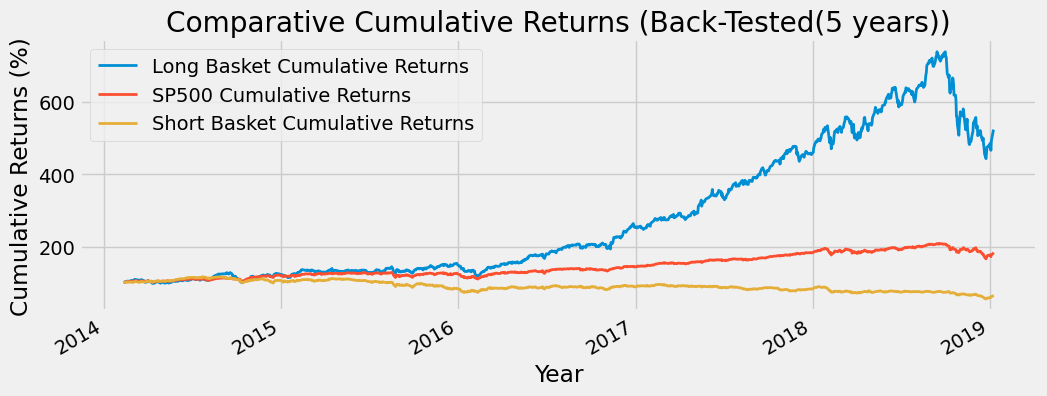

In [12]:
# Calculate the cumulative returns for the SP500, long basket, and short basket
cumulative_returns_past_5y = calculate_cumulative_returns(lagged_closed_price_past_5y)
long_cumulative_returns_past_5y = calculate_cumulative_returns(long_lagged_closed_price_past_5y)
short_cumulative_returns_past_5y = calculate_cumulative_returns(short_lagged_closed_price_past_5y)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
long_cumulative_returns_past_5y.plot(label='Long Basket Cumulative Returns', lw=2) # lw is line width
cumulative_returns_past_5y.plot(label='SP500 Cumulative Returns', lw =2)
short_cumulative_returns_past_5y.plot(label='Short Basket Cumulative Returns', lw=2)

plt.legend()
plt.title('Comparative Cumulative Returns (Back-Tested(5 years))')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()

## Monthly Potfolio Return Bar Charts (Pos/Neg coloring) vs SP500

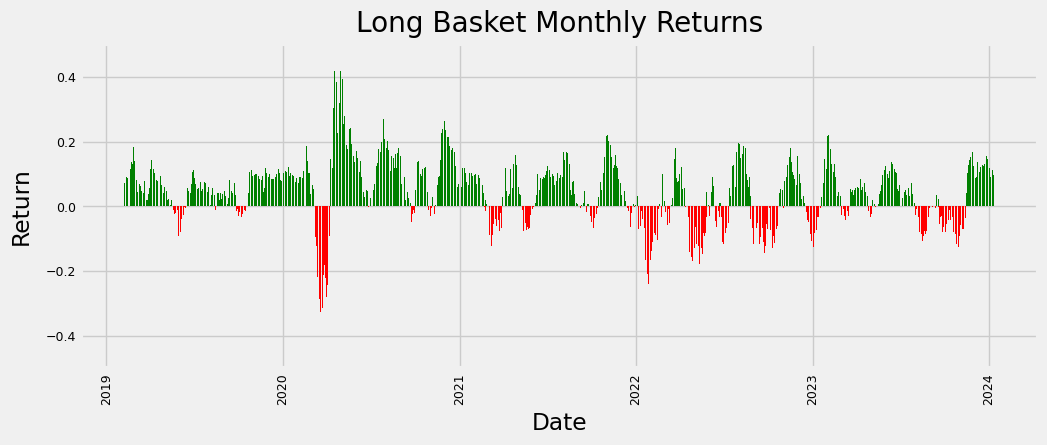

In [13]:
# Calculate 20-day returns, take the mean, drop NaNs
long_monthly_returns = long_lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = long_monthly_returns.index
ydata = long_monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in long_monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('Long Basket Monthly Returns', pad=9)
plt.show()

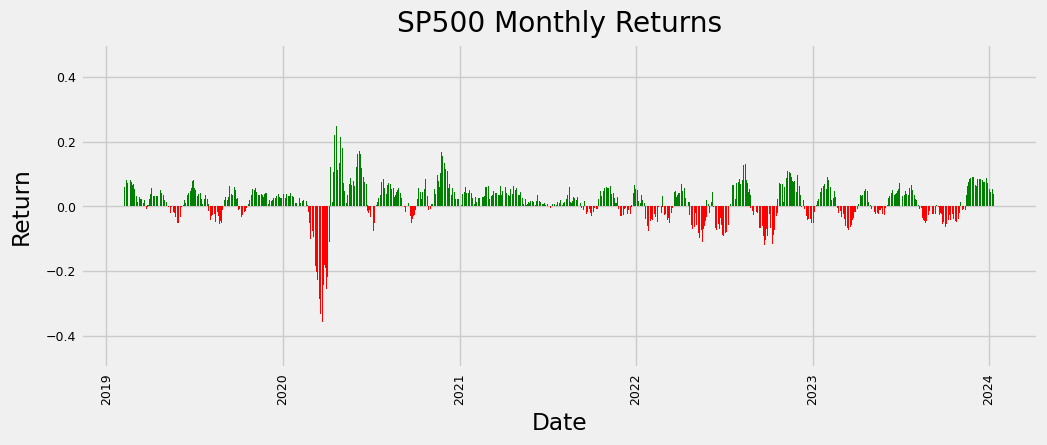

In [14]:
# Calculate 20-day returns, take the mean, drop NaNs
monthly_returns = lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = monthly_returns.index
ydata = monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('SP500 Monthly Returns', pad=9)
plt.show()

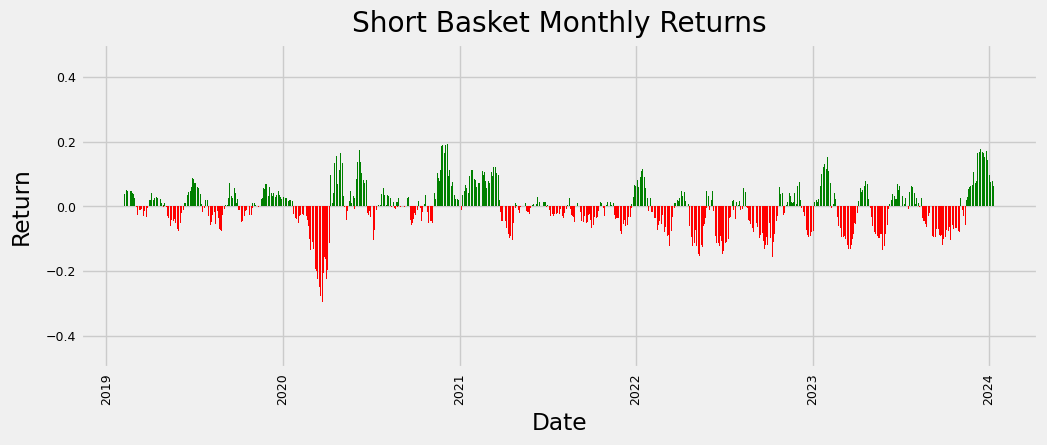

In [15]:
# Calculate 20-day returns, take the mean, drop NaNs
short_monthly_returns = short_lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = short_monthly_returns.index
ydata = short_monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in short_monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('Short Basket Monthly Returns', pad=9)
plt.show()

## Monthly return for long picks vs short picks vs SP500

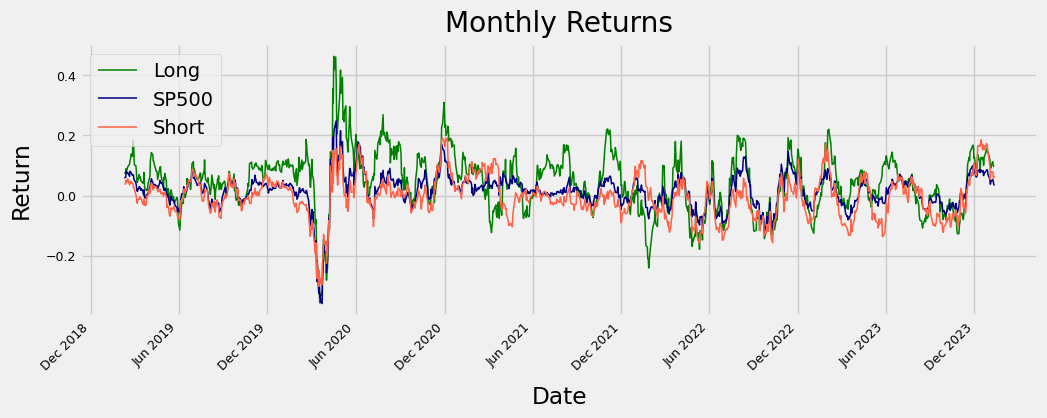

In [16]:
# Three plots 
plt.style.use('fivethirtyeight')
long_monthly_returns.plot(figsize=(11,4), label = 'Long', color = 'g', lw=1.1)
monthly_returns.plot(figsize=(11,4), label = 'SP500', color ='navy', lw = 1.1)
short_monthly_returns.plot(figsize=(11,4),label= 'Short', color = 'tomato', lw=1.1)

# Plot configurations 
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y',))
plt.xticks(rotation=45)
plt.tick_params(axis='both', labelsize=9)
plt.ylabel('Return',labelpad=9)
plt.xlabel('Date',labelpad=9)
plt.title('Monthly Returns',pad=9)
plt.show()

# Extra Credit : Portfolio weights
## Imported class from Efficient Frontier 

In [17]:
%%capture 
import os
import sys
# ^ this is used to suppress the output of the cell

# Getting the directory for the module were going to import
current_dir = os.getcwd()[:-17] #removing the last 17 characters (current directory)
target_dir = current_dir + 'Efficient-Frontier'

# Add the directory containing the module to the Python path
sys.path.insert(0, target_dir)

from Efficient_Frontier import EfficientFrontier

In [18]:
ef = EfficientFrontier(sp500[long_basket.index])
ef.calculate_portfolio() #Printing Annual Returns

TSLA    1.419899
MRNA    1.567426
NVDA    1.628755
ENPH    1.608859
NVR     1.230088
BLDR    1.448932
CMG     1.214659
AZO     1.193919
AMD     1.547297
FCX     1.172608
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


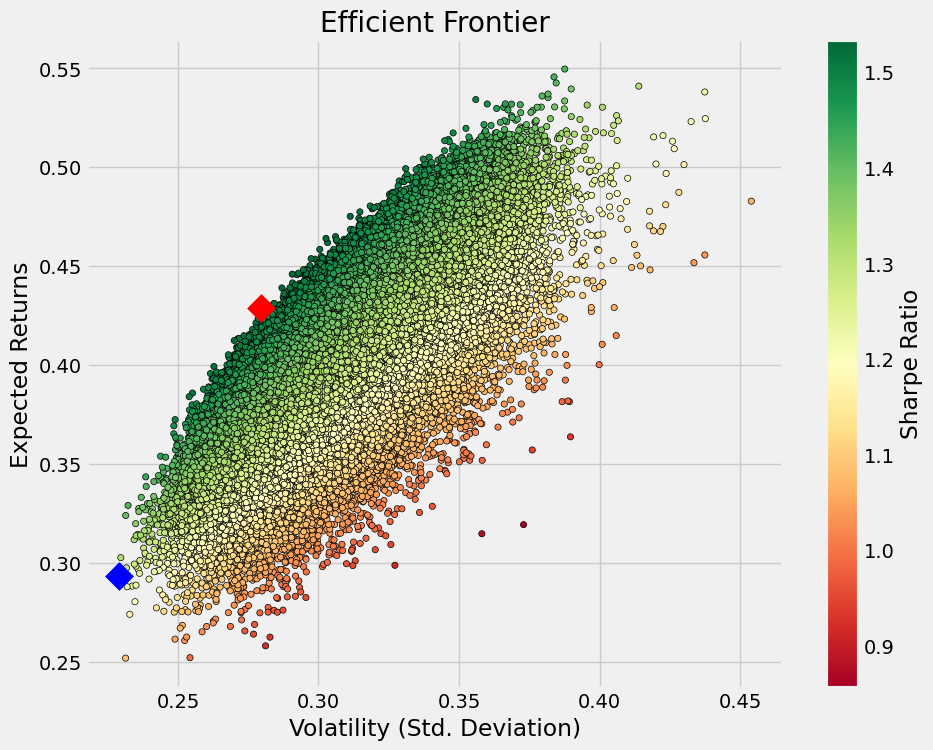

In [19]:
ef.plot_frontier()

In [20]:
ef.get_optimal_portfolio()

              Minimum Risk Adjusted Values  Max Risk Adjusted Values
Returns                           0.293425                  0.428996
Volatility                        0.228859                  0.279630
Sharpe Ratio                      1.282122                  1.534156
TSLA Weight                       0.003314                  0.013001
MRNA Weight                       0.112095                  0.129189
NVDA Weight                       0.093934                  0.253847
ENPH Weight                       0.000712                  0.080542
NVR Weight                        0.329809                  0.041076
BLDR Weight                       0.005461                  0.125689
CMG Weight                        0.058285                  0.078325
AZO Weight                        0.300035                  0.242619
AMD Weight                        0.008729                  0.015169
FCX Weight                        0.087626                  0.020545
